In [1]:
import pickle

import scanpy as sc
import numpy as np
import pandas as pd

from fbpca import pca
from geosketch import gs

import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

from scover.data import utils as scu

mpl.rcParams['figure.figsize'] = (6, 4)

## Load dataset

For this example, I am using the Marrow dataset from FACS-sorted Smart-seq2 datasets from Tabula Muris ([link](https://doi.org/10.6084/m9.figshare.5829687.v8), [the dataset is licensed CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/)). 

I'm starting from a pre-made Scanpy/Anndata object with existing PCA and UMAP embeddings:

In [2]:
ad = sc.read("data/Marrow.h5ad")

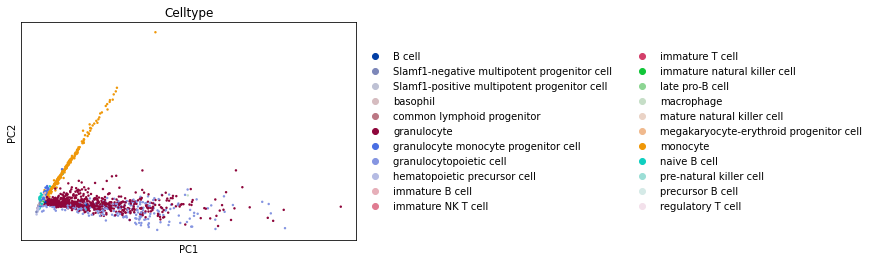

In [3]:
sc.pl.pca(ad, color='Celltype')

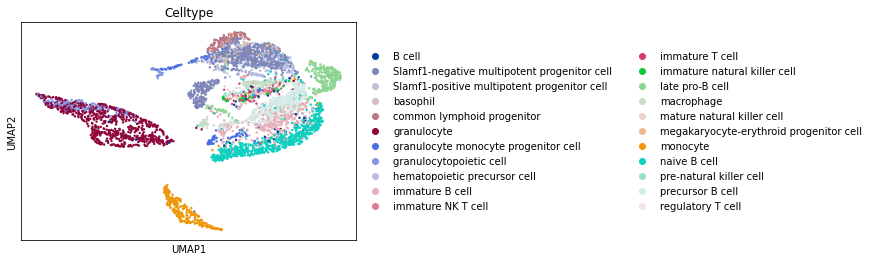

In [4]:
sc.pl.umap(ad, color='Celltype')

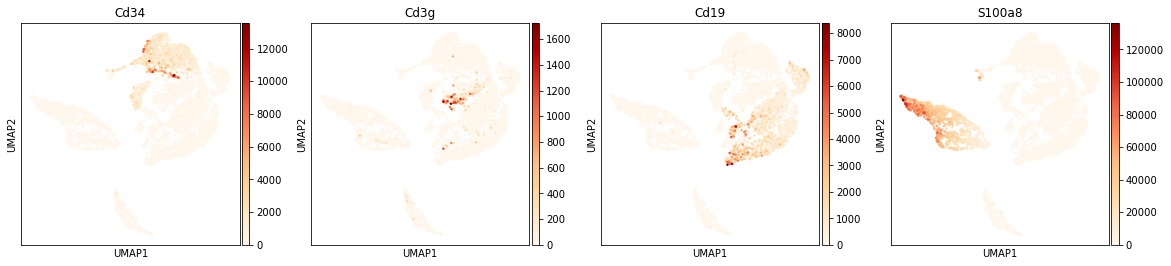

In [5]:
mpl.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(ad,
           color=["Cd34", "Cd3g", "Cd19", "S100a8"],
           gene_symbols="symbol",
           cmap="OrRd")

## Selecting seed cells

Here, I select an initial set of cells for the K-nearest neighbour calculation by evenly sampling across UMAP space using geometric sketching:

In [6]:
N_seeds = 100
sketch_index = gs(ad.obsm['X_umap'], N_seeds, replace=False)
sketch_index[0:10]

[74, 134, 157, 241, 370, 388, 419, 515, 534, 591]

In [7]:
ad_sketch = ad[sketch_index,:]
ad_sketch.obsm["X_pca"] = ad.obsm['X_pca'][sketch_index,:]
ad_sketch.obsm["X_umap"] = ad.obsm['X_umap'][sketch_index,:]

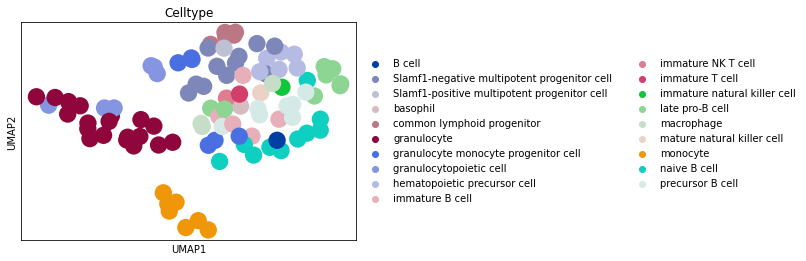

In [8]:
mpl.rcParams['figure.figsize'] = (6, 4)
sc.pl.umap(ad_sketch, color='Celltype')

## Pool dataset

Pool dataset with 80 neighbours:

In [9]:
ad_pooled, seed_selection, pseudobulk_idx = scu.pool_anndata(
    ad,
    neighbors=80,
    seed_selection=sketch_index,
    return_selection=True,
    log_transform=True,
    n_seed_cells=len(sketch_index)
)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  0%|          | 0/100 [00:00<?, ?it/s]

## Calculate PCA & UMAP

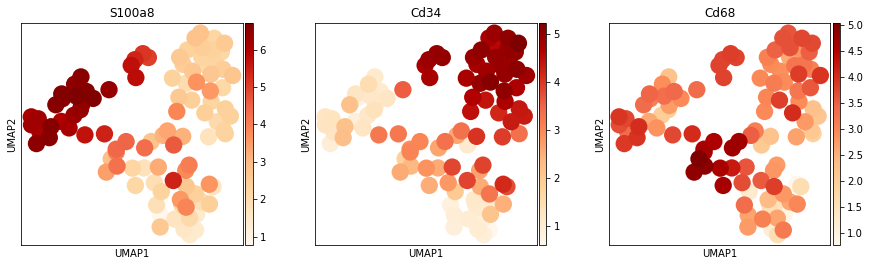

In [10]:
sc.tl.pca(ad_pooled, svd_solver='arpack', n_comps=40)
sc.pp.neighbors(ad_pooled)
sc.tl.umap(ad_pooled)

mpl.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(ad_pooled, color=['S100a8', 'Cd34', 'Cd68'], cmap='OrRd')

## Annotate with most abundant celltype in pool

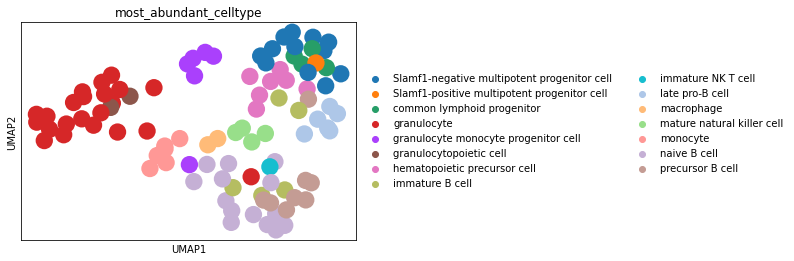

In [11]:
celltype_matrix_in_pools = np.array(ad.obs['Celltype'])[pseudobulk_idx]
celltypes_in_pools = pd.DataFrame(
    np.array([
        np.count_nonzero(celltype_matrix_in_pools == x, axis=1).T
        for x in list(set(ad.obs['Celltype']))
    ]).T,
    columns=[x + "_count" for x in list(set(ad.obs['Celltype']))],
    index=ad_pooled.obs_names)
ad_pooled.obs['most_abundant_celltype'] = np.array(
    list(set(ad.obs['Celltype'])))[np.argmax(np.array(celltypes_in_pools),
                                             axis=1)]

mpl.rcParams['figure.figsize'] = (6, 4)
sc.pl.umap(ad_pooled, color='most_abundant_celltype')

In [12]:
ad_pooled.obs[celltypes_in_pools.columns] = celltypes_in_pools

It is possible to look at the amount of cells included in the pool for a given celltype:

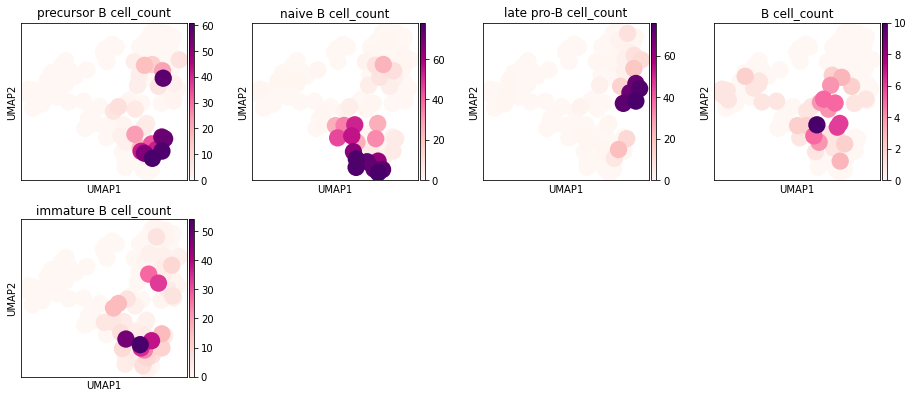

In [13]:
mpl.rcParams['figure.figsize'] = (3, 3)
sc.pl.umap(ad_pooled,
           color=[x for x in ad_pooled.obs.columns if "B cell" in x],
           cmap="RdPu")

In [14]:
sp_b = (ad.X.toarray() == 0).sum() / ad.shape[0] / ad.shape[1]
sp_a = (ad_pooled.X == 0).sum() / ad_pooled.shape[0] / ad_pooled.shape[1]
print(f"Sparsity before: {round(sp_b*100, 2)}%")
print(f"Sparsity after:  {round(sp_a*100, 2)}%")

Sparsity before: 86.49%
Sparsity after:  44.09%


## Save dataset

In [15]:
ad_pooled.write("data/Marrow_pooled.h5ad")
pickle.dump(pseudobulk_idx, 
            open("data/Marrow_pseudobulk_idx.p", "wb"))